<h1>Problem Definition</h1>

<p>The focus of this project will be <strong>Sonar Mines vs Rocks dataset.</strong> the problem is to predict metal or rock objects from sonar.</p>

<p>Note that the pattern from each instances are set of <strong>60 numbers</strong> in the range of <strong>0.0 </strong> to <strong>1.0</strong> and represents the energy within a particular <strong>frequency band</strong> which integrated with a certain period of time.</p>

<p>Labels are associated with the letter <strong>R</strong> if the object is a <strong>rock</strong> and then <strong>M</strong> if it is a <strong>mine or metal cylinder.</strong></p>

<h1>Load Libraries</h1>
<p>Let's proceed by loading the all of the required libraries for this problem.</p>

In [1]:
import seaborn as sn
import missingno as msno

from matplotlib import pyplot

from pandas import read_csv
from pandas import concat
from pandas.plotting import scatter_matrix
from pandas import DataFrame
from pandas import Series
from pandas import Index
from pandas import set_option

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from numpy import ndarray
from numpy import arange
from numpy import set_printoptions

from pickle import dump
from pickle import load

from typing import Tuple
from typing import List
from typing import Dict
from typing import Set

In [3]:
def main() -> None:
	df: DataFrame = read_csv(PATH, header=None)
	# understand_data(df)

	# Prepare Data
	n_array: ndarray = df.values	
	X: ndarray = df.iloc[:, 0 : 60].astype(float)
	Y: ndarray = df.iloc[:, 60]
	X_train, X_validation, Y_train, Y_validation = get_resampling_data(X, Y, 10, 7)
	feature_selection(X, Y)

	baseline_models: List[set] = [
		("LR", LogisticRegression()),
		("LDA", LinearDiscriminantAnalysis()),
		("KNN", KNeighborsClassifier()),
		("CART", DecisionTreeClassifier()),
		("NB", GaussianNB()),
		("SVM", SVC())
	]

	#Evaluation Algorithm Baseline
	baseline_results: List[set] = evaluate_algorithms_baseline(10, 7, "accuracy", X_train, Y_train, baseline_models)
	show_whisker_plots_for_evaluation(baseline_results[0], baseline_results[1], "Evaluation Algorithms Baseline")

	#Evaluation Alagorithms Standardize
	pipelines: List[set]  = [
		("ScaledLR", Pipeline([("Scaler", StandardScaler()),("LR", LogisticRegression())])),
		("ScaledLDA", Pipeline([("Scaler", StandardScaler()),("LDA", LinearDiscriminantAnalysis())])),
		("ScaledKNN", Pipeline([("Scaler", StandardScaler()),("KNN", KNeighborsClassifier())])),
		("ScaledCART", Pipeline([("Scaler", StandardScaler()),("CART", LogisticRegression())])),
		("ScaledNB", Pipeline([("Scaler", StandardScaler()),("NB", GaussianNB())])),
		("ScaledSVM", Pipeline([("Scaler", StandardScaler()),("SVM", SVC())]))
	]

	scaled_results: list = evaluate_algorithms_standardize(10, 7, "accuracy", X_train, Y_train, pipelines)
	show_whisker_plots_for_evaluation(scaled_results[0], scaled_results[1], "Evaluation Algorithms Standardize")

	#Improve Accuracy
	#Algorithm Tuning
	tune_svm(X_train, Y_train)
	tune_knn(X_train, Y_train)
	# Ensemble
	# Bagging
	bagging_ensembles: List[set] = [
		("RF", RandomForestClassifier()),
		("ET", ExtraTreesClassifier()),
		("BC", BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=7))
	]
	bagging_ensembles_results: list = make_ensemble_methods(bagging_ensembles, X_train, Y_train)
	show_whisker_plots_for_evaluation(bagging_ensembles_results[0], bagging_ensembles_results[1], "Ensemble Bagging Algorithm Comparison")
	#Boosting
	boosting_ensembles: List[set] = [
		("AB", AdaBoostClassifier()),
		("GBM", GradientBoostingClassifier())
	]
	boosting_ensembles_results: list = make_ensemble_methods(boosting_ensembles, X_train, Y_train)
	show_whisker_plots_for_evaluation(boosting_ensembles_results[0], boosting_ensembles_results[1], "Ensemble Boosting Algorithm Comparison")

	#Majority Voting
	voting_ensembles: List[set] = [
		("KNN2", KNeighborsClassifier(n_neighbors=2)),
		("KNN4", KNeighborsClassifier(n_neighbors=4)),
		("KNN6", KNeighborsClassifier(n_neighbors=6)),
		("KNN8", KNeighborsClassifier(n_neighbors=8)),
		("KNN10", KNeighborsClassifier(n_neighbors=10))
	]
	scores: float = majority_voting(voting_ensembles, X_train, Y_train)

	#Finalize Model
	svc_model: SVC = finalize_model(X_train, Y_train, X_validation, Y_validation)
	filename: str = "svm_finalized_model.sav"
	save_model(filename, svc_model)
	load_model(filename, X_validation, Y_validation)
	
def understand_data(df) -> None:
    is_there_any_duplicates: bool = find_duplicates(df)
    if is_there_any_duplicates:
        df_duplicates = get_duplicates_row(df, "")
        df = drop_duplicates(df)
    is_there_any_missing_values: bool = check_missing_values(df)

    if is_there_any_missing_values == True:
        df = clean_data(df)
    
    is_done: bool = data_profiling(df)
    if is_done:
        visualization(df)

def data_profiling(df) -> bool:
    df_head: DataFrame = get_peek(df, 5)
    df_tail: DataFrame = get_tail(df, 5)
    df_dimension: Tuple = get_dimension(df)
    df_columns: Index = get_columns(df)
    get_data_information(df)
    df_data_types: Series = get_data_types(df)

    df_descriptive_statistics: DataFrame = get_descriptive_statistics(df)
    df_correlation: DataFrame = get_correlation(df, "pearson")
    df_skew: DataFrame = get_skew(df)
    df_kurtosis: DataFrame = get_kurtosis(df)
    df_null_values: Series = show_missing_values(df)
    return True

def visualization(df) -> None:
	# Univariate 
	show_histogram(df)
	show_density_plots(df)

	# Multivariate 
	df_correlation: DataFrame = get_correlation(df, "pearson")
	show_correlation_plot(df_correlation)

	# Class Distribution
	df_class_distribution: DataFrame = get_class_distribution(df, 60)
	rocks: int = df_class_distribution.iloc[1]
	sonar: int = df_class_distribution.iloc[0]
	pyplot.title("Class Distribution")
	pyplot.pie([rocks, sonar], labels=["Rock", "Sonar"])
	show_plot()

def feature_selection(X, Y) -> None:
	univariate_selection(X, Y)
	recursive_feature_elmination(X, Y)
	feature_importance(X, Y)
	
def univariate_selection(X, Y) -> bool:
	# Univariate Selection
	test = SelectKBest(score_func=chi2, k=4)
	fit = test.fit(X, Y)
	print(fit.scores_)
	cols = test.get_support()
	features_df_new = X.iloc[:,cols]
	print(features_df_new)
	set_printoptions(precision=3)
	features = fit.transform(X)
	print(features[:5])
	return True

def recursive_feature_elmination(X, Y) -> bool:
	rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3)
	fit = rfe.fit(X, Y)
	for i in range(X.shape[1]):
		print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))
	return True

def feature_importance(X, Y) -> bool:
	model = ExtraTreesClassifier()
	model.fit(X, Y)
	set_printoptions(precision=3)
	print(model.feature_importances_)
	return True

def clean_data(df, default=True) -> DataFrame:
    if default:
        return impute_missing_value(df)

def get_kurtosis(df) -> DataFrame:
    return df.kurtosis()

def get_resampling_data(X, Y, size, state):
	return train_test_split(X, Y, test_size=size, random_state=state)

def get_missing_value(df):
	mask = df.isnull()
	total = mask.sum()
	percent = 100 * mask.mean()
	missing_value = concat([total, percent], axis=1, join="outer", keys=["count_missing", "percentage_missing"])
	missing_value.sort_values(by="percentage_missing", ascending=False, inplace=True)
	return missing_value

def get_class_distribution(df, name):
	return df.groupby(name).size()

def get_missing_value_percentage(df):
	return round(100 * (df.isnull().sum() / len(df)), 2)

def get_unique_values_per_column(df, name) -> ndarray:
	return df[name].unique()

def get_unique_values(df) -> Series:
	return df.nunique()

def get_skew(df) -> DataFrame:
	return df.skew()

def get_correlation(df, method) -> DataFrame:
	return df.corr(method=method)

def get_descriptive_statistics(df) -> DataFrame:
	return df.describe()

def get_peek(df, n) -> DataFrame:
	return df.head(n)

def get_tail(df, n) -> DataFrame:
	return df.tail(n)

def get_dimension(df) -> Tuple:
	return df.shape

def get_data_types(df) -> Series:
	return df.dtypes

def get_data_information(df):
	return df.info()

def get_columns(df) -> Index:
	return df.columns

def get_duplicates_row(df, name, all_rows=True):
	if all_rows:
		return df[df.duplicated()]
	else:
		return df[df.duplicated(name)]

def find_duplicates(df) -> bool:
	return df.duplicated().any()

def check_missing_values(df) -> bool:
	return df.isnull().values.any()

def drop_duplicates(df):
	return df.drop_duplicates()

def show_missing_values(df) -> Series:
	return df.isnull().sum()

def run_option() -> None:
	set_option("display.width", 100)
	set_option("precision", 3)

def impute_missing_value(df) -> DataFrame:
	return df.fillna(0)

def missing_plot(df) -> None:
	mask = df.isnull()
	nullable_columns = df.columns[mask.any()].tolist()
	msno.matrix(df[nullable_columns].sample(500))
	show_plot()

def missing_heat_map(df) -> None:
	mask = df.isnull()
	nullable_columns = df.columns[mask.any()].tolist()
	msno.heatmap(df[nullable_columns], figsize=(18, 18))
	show_plot()

def show_density_plots(df) -> None:
	df.plot(kind="density", subplots=True, layout=(8, 8), sharex=False)
	show_plot()

def show_histogram(df) -> None:
	df.hist()
	show_plot()

def show_scatter_plot(df) -> None:
	scatter_matrix(df)
	show_plot()

def show_whisker_plots_for_evaluation(results, names, title) -> None:
	fig = pyplot.figure()
	fig.suptitle(title)
	ax = fig.add_subplot(111)
	pyplot.boxplot(results)
	ax.set_xticklabels(names)
	show_plot()

def show_whisker_plots(df) -> None:
	df.plot(kind="box", subplots=True, layout=(3, 3), sharex=False, sharey=False)
	show_plot()

def show_correlation_plot(correlations) -> None:
	fig = pyplot.figure()
	ax = fig.add_subplot(111)
	cax = ax.matshow(correlations, vmin=-1, vmax=1, interpolation="none")
	fig.colorbar(cax)
	show_plot()

def show_plot() -> None:
	pyplot.show()

def evaluate_algorithms_baseline(fold, seed, metric, X, Y, models) -> list:
	evaluation_results: list = []
	model_name: list = []
	stash_models: list = []
	i: int= 0
	model_length: int = len(models)
	while i <= model_length:
		el = models[i]
		kfold = KFold(n_splits=fold, random_state=seed, shuffle=True)
		score = cross_val_score(el[1], X, Y, cv=kfold, scoring=metric)
		evaluation_results.append(score)
		model_name.append(el[0])
		stash_models.append(el[1])
		print(f"{el[0]} Mean estimated Accuracy: {score.mean()*100:.3f}%")
		print(f"{el[0]} Estimated Standard Deviation: {score.std()*100:.3f}%")
		i += 1
		if i == model_length:
			return evaluation_results, model_name, stash_models

def evaluate_algorithms_standardize(fold, seed, metric, X, Y, pipelines) -> list:
	i = 0
	model_results = []
	model_name = []
	stash_models = []
	pipelines_length = len(pipelines)
	while i <= pipelines_length:
		el = pipelines[i]
		kfold = KFold(n_splits=10, random_state=7, shuffle=True)
		cv_results = cross_val_score(el[1], X, Y, cv=kfold, scoring=metric)
		print(f"Name:{el[0]} Mean:{cv_results.mean()*100:.3f}% STD:{cv_results.std()*100:.3f}%")
		model_results.append(cv_results)
		model_name.append(el[0])
		stash_models.append(el[1])
		i += 1
		if i == pipelines_length:
			return model_results, model_name, stash_models

def tune_svm(X, Y) -> None:
	pipe: List[set] = Pipeline([("Scaler", StandardScaler()), ("SVC", SVC())])
	param_grid: dict = {"SVC__C":  [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0], "SVC__kernel": ["linear", "poly", "rbf", "sigmoid"]}
	kfold: KFold = KFold(n_splits=10, random_state=7, shuffle=True)
	grid: GridSearchCV = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=kfold)
	grid_result: GridSearchCV = grid.fit(X, Y)
	print(f"SVM Best score{grid_result.best_score_} Params:{grid_result.best_params_}")
	svm_means: ndarray = grid_result.cv_results_["mean_test_score"]
	svm_stds: ndarray = grid_result.cv_results_["std_test_score"]
	svm_params: ndarray = grid_result.cv_results_["params"]
	for mean, std, param in zip(svm_means, svm_stds, svm_params):
		print(f"SVM mean={mean}, std={std}, param={param}")	

def tune_knn(X, Y) -> None:
	pipe: List[set] = Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsClassifier())])
	param_grid: dict= {"KNN__n_neighbors":range(1, 21, 2), "KNN__metric": ["euclidean", "manhattan", "minkowski"], "KNN__weights": ["uniform", "distance"] }
	kfold: KFold = KFold(n_splits=10, random_state=7, shuffle=True)
	grid: GridSearchCV = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=kfold)
	grid_result: GridSearchCV = grid.fit(X, Y)
	print(f"KNN Best score {grid_result.best_score_} Params:{grid_result.best_params_}")
	svm_means: ndarray = grid_result.cv_results_["mean_test_score"]
	svm_stds: ndarray = grid_result.cv_results_["std_test_score"]
	svm_params: ndarray = grid_result.cv_results_["params"]
	for mean, std, param in zip(svm_means, svm_stds, svm_params):
		print(f"KNN mean={mean}, std={std}, param={param}")		


def make_ensemble_methods(ensembles, X_train, Y_train) -> None:
	ensembles_results: list = []
	ensembles_names: list = []
	j = 0
	ensembles_length: int = len(ensembles)
	while j <= ensembles_length:
		el = ensembles[j]
		kfold = KFold(n_splits=10, random_state=7, shuffle=True)
		cv_result = cross_val_score(el[1], X_train, Y_train, cv=kfold, scoring="accuracy")
		ensembles_results.append(cv_result)
		ensembles_names.append(el[0])
		print(f"Ensemble method:{el[0]} mean:{cv_result.mean()*100:.3f}% std:{cv_result.std()*100:.3f}%")
		j += 1
		if j == ensembles_length:
			return ensembles_results, ensembles_names

def majority_voting(ensembles, X_train, Y_train) -> float:
	voting_ensembles: VotingClassifier = VotingClassifier(ensembles, voting="hard")
	kfold: KFold = KFold(n_splits=10, random_state=7, shuffle=True)
	voting_results = cross_val_score(voting_ensembles, X_train, Y_train, cv=kfold)
	voting_mean: float = voting_results.mean()* 100
	voting_std: float = voting_results.std() * 100
	return voting_mean, voting_std

def finalize_model(X_train, Y_train, X_validation, Y_validation):
    scaler = StandardScaler().fit(X_train)
    rescaledX = scaler.transform(X_train)
    model = SVC(C=5, kernel="rbf")
    model.fit(rescaledX, Y_train)
    rescaledValidationX = scaler.transform(X_validation)
    predictions = model.predict(rescaledValidationX)
    print(f"Accuracy Score {accuracy_score(Y_validation, predictions)*100:.3f}%")
    print(f"Confusion Matrix {confusion_matrix(Y_validation, predictions)}")
    print(f"Classification Report {classification_report(Y_validation, predictions)}")
    return model

def save_model(file_name, model) -> None:
	filename: str = file_name
	mode: str = "wb"
	dump(model, open(filename, mode))

def load_model(file_name, X_validation, Y_validation) -> None:
	load_model = load(open(file_name, "rb"))
	result = load_model.score(X_validation, Y_validation)
	print(result)

<h1>Exploratory Data Analysis</h1>
<p>Under EDA, we have <strong>Data Profiling, Imputation Strategies, and Visualization</strong>.</p>

<h2>Data Profiling</h2>

In [5]:
PATH: str = "./dataset.csv"
df: DataFrame = read_csv(PATH, header=None)
df

0       1       2       3       4       5       6       7       8   \
0    0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1    0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2    0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3    0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4    0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
203  0.0187  0.0346  0.0168  0.0177  0.0393  0.1630  0.2028  0.1694  0.2328   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
205  0.0522  0.0437  0.0180  0.0292  0.0351  0.1171  0.1257  0.1178  0.1258   
206  0.0303  0.0353  0.0490  0.0608  0.0167  0.1354  0.1465  0.1123  0.1945   
207  0.0260  0.0363  0.0136  0.0272  0.0214  0.0338  0.0655  0.1400  0.1843   

         9   ...      51      52      53      54      55      56      57  \
0    0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1    0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2    0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3    0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4    0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
203  0.2684  ...  0.0116  0.0098  0.0199  0.0033  0.0101  0.0065  0.0115   
204  0.2154  ...  0.0061  0.0093  0.0135  0.0063  0.0063  0.0034  0.0032   
205  0.2529  ...  0.0160  0.0029  0.0051  0.0062  0.0089  0.0140  0.0138   
206  0.2354  ...  0.0086  0.0046  0.0126  0.0036  0.0035  0.0034  0.0079   
207  0.2354  ...  0.0146  0.0129  0.0047  0.0039  0.0061  0.0040  0.0036   

         58      59  60  
0    0.0090  0.0032   R  
1    0.0052  0.0044   R  
2    0.0095  0.0078   R  
3    0.0040  0.0117   R  
4    0.0107  0.0094   R  
..      ...     ...  ..  
203  0.0193  0.0157   M  
204  0.0062  0.0067   M  
205  0.0077  0.0031   M  
206  0.0036  0.0048   M  
207  0.0061  0.0115   M  

[208 rows x 61 columns]

<p>Let's double check if we have <strong>duplicates</strong> to drop. </p>

In [6]:
is_there_any_duplicates: bool = find_duplicates(df)
print(f"Is there any duplicates? {is_there_any_duplicates}")

Is there any duplicates? False


<p>No <strong>duplicates</strong> at all, not let's see if we have <strong>NaN</strong> values.</p>

In [9]:
is_there_any_missing_values: bool = check_missing_values(df)
print(f"Is there any missing values? {is_there_any_missing_values}")

Is there any missing values? False


<p>Let's begin with <strong>Data Profiling</strong></p>

In [10]:
df_head: DataFrame = get_peek(df, 5)
df_head

0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      51      52      53      54      55      56      57  \
0  0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1  0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2  0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3  0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4  0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   

       58      59  60  
0  0.0090  0.0032   R  
1  0.0052  0.0044   R  
2  0.0095  0.0078   R  
3  0.0040  0.0117   R  
4  0.0107  0.0094   R  

[5 rows x 61 columns]

<p><strong>61 columns</strong> are huge and every instances are in <strong>float</strong> type. Let's see the last instances.</p>

In [11]:
df_tail: DataFrame = get_tail(df, 5)
df_tail

0       1       2       3       4       5       6       7       8   \
203  0.0187  0.0346  0.0168  0.0177  0.0393  0.1630  0.2028  0.1694  0.2328   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
205  0.0522  0.0437  0.0180  0.0292  0.0351  0.1171  0.1257  0.1178  0.1258   
206  0.0303  0.0353  0.0490  0.0608  0.0167  0.1354  0.1465  0.1123  0.1945   
207  0.0260  0.0363  0.0136  0.0272  0.0214  0.0338  0.0655  0.1400  0.1843   

         9   ...      51      52      53      54      55      56      57  \
203  0.2684  ...  0.0116  0.0098  0.0199  0.0033  0.0101  0.0065  0.0115   
204  0.2154  ...  0.0061  0.0093  0.0135  0.0063  0.0063  0.0034  0.0032   
205  0.2529  ...  0.0160  0.0029  0.0051  0.0062  0.0089  0.0140  0.0138   
206  0.2354  ...  0.0086  0.0046  0.0126  0.0036  0.0035  0.0034  0.0079   
207  0.2354  ...  0.0146  0.0129  0.0047  0.0039  0.0061  0.0040  0.0036   

         58      59  60  
203  0.0193  0.0157   M  
204  0.0062  0.0067   M  
205  0.0077  0.0031   M  
206  0.0036  0.0048   M  
207  0.0061  0.0115   M  

[5 rows x 61 columns]

<p>I noticed that last rows are being labeled as <strong>M (metal)</strong> while on the top is <strong>R (rock)</strong> then floating precision is <strong>4</strong> decimal places, interesting pattern.</p>

In [12]:
df_dimension: Tuple = get_dimension(df)
print(f"No. of instances: {df_dimension[0]}")
print(f"No. of features: {df_dimension[1]}")

No. of instances: 208
No. of features: 61


<p>Good thing there were no <strong>missing</strong> values. Let's see each <strong>columns</strong></p>

In [13]:
df_columns: Index = get_columns(df)
df_columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
           dtype='int64')

<p>Apparently, <strong>columns</strong> are set to be integers with <strong>ascending</strong> order. To make it detailed let's generate dataset <strong>information.</strong></p>

In [14]:
get_data_information(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

<p>From <strong>column 0 to 50</strong> are <strong>floating</strong> point values and then last feature is <strong>object.</strong></p>

In [15]:
df_data_type: Series = get_data_types(df)
df_data_type

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
56    float64
57    float64
58    float64
59    float64
60     object
Length: 61, dtype: object

<p>Let's summarize the distribution of each attribute.</p>

In [16]:
df_descriptive_statistics: DataFrame = get_descriptive_statistics(df)
df_descriptive_statistics

0           1           2           3           4           5   \
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000   
mean     0.029164    0.038437    0.043832    0.053892    0.075202    0.104570   
std      0.022991    0.032960    0.038428    0.046528    0.055552    0.059105   
min      0.001500    0.000600    0.001500    0.005800    0.006700    0.010200   
25%      0.013350    0.016450    0.018950    0.024375    0.038050    0.067025   
50%      0.022800    0.030800    0.034300    0.044050    0.062500    0.092150   
75%      0.035550    0.047950    0.057950    0.064500    0.100275    0.134125   
max      0.137100    0.233900    0.305900    0.426400    0.401000    0.382300   

               6           7           8           9   ...          50  \
count  208.000000  208.000000  208.000000  208.000000  ...  208.000000   
mean     0.121747    0.134799    0.178003    0.208259  ...    0.016069   
std      0.061788    0.085152    0.118387    0.134416  ...    0.012008   
min      0.003300    0.005500    0.007500    0.011300  ...    0.000000   
25%      0.080900    0.080425    0.097025    0.111275  ...    0.008425   
50%      0.106950    0.112100    0.152250    0.182400  ...    0.013900   
75%      0.154000    0.169600    0.233425    0.268700  ...    0.020825   
max      0.372900    0.459000    0.682800    0.710600  ...    0.100400   

               51          52          53          54          55          56  \
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000   
mean     0.013420    0.010709    0.010941    0.009290    0.008222    0.007820   
std      0.009634    0.007060    0.007301    0.007088    0.005736    0.005785   
min      0.000800    0.000500    0.001000    0.000600    0.000400    0.000300   
25%      0.007275    0.005075    0.005375    0.004150    0.004400    0.003700   
50%      0.011400    0.009550    0.009300    0.007500    0.006850    0.005950   
75%      0.016725    0.014900    0.014500    0.012100    0.010575    0.010425   
max      0.070900    0.039000    0.035200    0.044700    0.039400    0.035500   

               57          58          59  
count  208.000000  208.000000  208.000000  
mean     0.007949    0.007941    0.006507  
std      0.006470    0.006181    0.005031  
min      0.000300    0.000100    0.000600  
25%      0.003600    0.003675    0.003100  
50%      0.005800    0.006400    0.005300  
75%      0.010350    0.010325    0.008525  
max      0.044000    0.036400    0.043900  

[8 rows x 60 columns]

<p>I noticed that the value under <strong>mean</strong> has differing range. <strong>Data transformation</strong> may be some benefit from <strong>standardizing</strong> the data.</p>

In [17]:
correlation_type: str = "pearson"
df_correlation: DataFrame = get_correlation(df, correlation_type)
df_correlation

0         1         2         3         4         5         6   \
0   1.000000  0.735896  0.571537  0.491438  0.344797  0.238921  0.260815   
1   0.735896  1.000000  0.779916  0.606684  0.419669  0.332329  0.279040   
2   0.571537  0.779916  1.000000  0.781786  0.546141  0.346275  0.190434   
3   0.491438  0.606684  0.781786  1.000000  0.726943  0.352805  0.246440   
4   0.344797  0.419669  0.546141  0.726943  1.000000  0.597053  0.335422   
5   0.238921  0.332329  0.346275  0.352805  0.597053  1.000000  0.702889   
6   0.260815  0.279040  0.190434  0.246440  0.335422  0.702889  1.000000   
7   0.355523  0.334615  0.237884  0.246742  0.204006  0.471683  0.675774   
8   0.353420  0.316733  0.252691  0.247078  0.177906  0.327578  0.470580   
9   0.318276  0.270782  0.219637  0.237769  0.183219  0.288621  0.425448   
10  0.344058  0.297065  0.274610  0.271881  0.231684  0.333570  0.396588   
11  0.210861  0.194102  0.214807  0.175381  0.211657  0.344451  0.274432   
12  0.210722  0.249596  0.258767  0.215754  0.299086  0.411107  0.365391   
13  0.256278  0.273170  0.291724  0.286708  0.359062  0.396233  0.409576   
14  0.304878  0.307599  0.285663  0.278529  0.318059  0.367908  0.411692   
15  0.239079  0.261844  0.237017  0.248245  0.328725  0.353783  0.363086   
16  0.137845  0.152170  0.201093  0.223203  0.326477  0.293190  0.250024   
17  0.041817  0.042870  0.120587  0.194992  0.299266  0.235778  0.208057   
18  0.055227  0.040911  0.099303  0.189405  0.340543  0.226305  0.215495   
19  0.156760  0.102428  0.103117  0.188317  0.285737  0.206841  0.196496   
20  0.117663  0.075255  0.063990  0.142271  0.205088  0.174768  0.165827   
21 -0.056973 -0.074157 -0.026815  0.036010  0.152897  0.123770  0.063773   
22 -0.163426 -0.179365 -0.073400 -0.029749  0.073934  0.064081  0.009359   
23 -0.218093 -0.196469 -0.085380 -0.102975 -0.000624  0.027026  0.011982   
24 -0.295683 -0.295302 -0.214256 -0.206673 -0.067296 -0.043280 -0.057147   
25 -0.342865 -0.365749 -0.291974 -0.291357 -0.125675 -0.100309 -0.126074   
26 -0.341703 -0.337046 -0.263111 -0.294749 -0.169618 -0.129094 -0.179526   
27 -0.224340 -0.234386 -0.256674 -0.256074 -0.214692 -0.118645 -0.116848   
28 -0.199099 -0.228490 -0.290728 -0.300476 -0.283863 -0.156081 -0.129694   
29 -0.077430 -0.115301 -0.197493 -0.236602 -0.273350 -0.151186 -0.068142   
30 -0.048370 -0.055862 -0.106198 -0.190086 -0.214336 -0.054136 -0.096945   
31 -0.030444 -0.049683 -0.109895 -0.169987 -0.173485 -0.051934 -0.115871   
32 -0.031939 -0.108272 -0.170671 -0.164651 -0.200586 -0.144391 -0.127052   
33  0.031319 -0.004247 -0.099409 -0.083965 -0.140559 -0.070337 -0.077662   
34  0.098118  0.115824  0.017053  0.015200 -0.086529 -0.028815 -0.015531   
35  0.080722  0.132611  0.053070  0.039282 -0.073481 -0.023621  0.002979   
36  0.119565  0.169186  0.107530  0.063486 -0.064617 -0.064798 -0.001376   
37  0.209873  0.217494  0.130276  0.089887 -0.008620 -0.048745  0.065900   
38  0.208371  0.186828  0.110499  0.089346  0.063408  0.030599  0.080942   
39  0.099993  0.098350  0.074137  0.045141  0.061616  0.081119  0.112673   
40  0.127313  0.188226  0.189047  0.145241  0.098832  0.075797  0.041071   
41  0.213592  0.261345  0.233442  0.144693  0.125181  0.048763 -0.028720   
42  0.206057  0.186368  0.113920  0.050629  0.063706  0.034380 -0.025727   
43  0.157949  0.133018  0.071946 -0.008407  0.031575  0.048870  0.061404   
44  0.279968  0.285716  0.180734  0.087824  0.089202  0.085468  0.110813   
45  0.319354  0.304247  0.173649  0.080012  0.081964  0.029524  0.076537   
46  0.230343  0.255797  0.179528  0.046109  0.041419  0.016640  0.098925   
47  0.203234  0.265279  0.234896  0.121065  0.084435  0.067196  0.155221   
48  0.247560  0.313995  0.223074  0.133294  0.088128  0.080729  0.194720   
49  0.269287  0.245868  0.081096  0.077925  0.066751  0.017300  0.166112   
50  0.254450  0.320538  0.238110  0.174676  0.115936  0.171767  0.184152   
51  0.355299  0.434548  0.394076  0.374651  0.266617  0.25

<p>Looking at column <strong>10</strong> and <strong>4</strong> they are correlated. Let find this out in <strong>Visualization</strong> category.</p>

In [18]:
df_skew: DataFrame = get_skew(df)
df_skew

0     2.131088
1     2.155644
2     2.652518
3     3.401697
4     2.018141
5     1.248166
6     0.970820
7     1.481107
8     1.633870
9     1.281258
10    0.987813
11    0.588681
12    0.736584
13    1.022369
14    0.763964
15    0.694671
16    0.654480
17    0.525845
18    0.283182
19   -0.085331
20   -0.252741
21   -0.392289
22   -0.594350
23   -0.691861
24   -0.788909
25   -0.671580
26   -0.627843
27   -0.615447
28   -0.442007
29   -0.132390
30    0.259797
31    0.313420
32    0.423864
33    0.563296
34    0.591654
35    0.619868
36    0.676994
37    1.033366
38    0.908835
39    0.861280
40    0.863526
41    0.860110
42    0.909317
43    1.235086
44    1.366839
45    1.706674
46    1.790155
47    1.277722
48    1.273385
49    1.761714
50    2.716060
51    2.093976
52    1.060572
53    1.093090
54    1.789946
55    1.780805
56    1.653090
57    2.098330
58    1.737506
59    2.775754
dtype: float64

<p>Here is the <strong>skew result </strong>. Values closes to <strong>zero</strong> means <strong>less skew.</strong> Obviously, positive values leaning towards <strong>(right) positive skew.</strong>negative values is <strong>(left) negative skew.</strong></p>

In [31]:
df_kurtosis: DataFrame = get_kurtosis(df)
df_kurtosis

0      5.590145
1      7.091235
2     11.669560
3     20.736121
4      7.044579
5      2.572759
6      1.461410
7      2.802407
8      3.592943
9      1.820620
10     1.190935
11     0.036247
12     0.400126
13     1.576800
14     0.024567
15    -0.513149
16    -0.822584
17    -1.045141
18    -1.166215
19    -1.210104
20    -1.026724
21    -0.948883
22    -0.613532
23    -0.245873
24    -0.205343
25    -0.548768
26    -0.530026
27    -0.417756
28    -0.699993
29    -0.689771
30    -0.643969
31    -0.664265
32    -0.514710
33    -0.558206
34    -0.711456
35    -0.658919
36    -0.553239
37     0.623908
38     0.457845
39     0.761169
40     0.451796
41     0.532222
42     1.074928
43     1.416182
44     1.083385
45     3.065555
46     4.216863
47     1.848505
48     1.782252
49     4.402882
50    14.320998
51     7.006616
52     1.248923
53     0.935900
54     4.531085
55     5.367747
56     3.611717
57     6.762729
58     3.740889
59    14.740674
dtype: float64

<p>If the value from column is <strong>equal to 3 </strong> it is normal distribution. <strong>Greater than 3 </strong> dataset have heavier tails than normal distribution (more in the tails) while <strong>less than 3 ligther tails.</strong></p>

In [19]:
df_null_values: Series = show_missing_values(df)
df_null_values

0     0
1     0
2     0
3     0
4     0
     ..
56    0
57    0
58    0
59    0
60    0
Length: 61, dtype: int64

<p>According to this summary, no <strong>missing values</strong> was shown. Let's head to <strong>visualization</strong></p>

<h1>Visualization</h1>

<h2>Univariate Plots</h2>

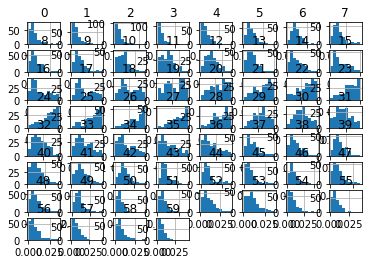

In [20]:
show_histogram(df)

<p>As you can see, there are a lot <strong>Gaussian-like distributions</strong> and perhaps some <strong>exponential like distributions</strong>for other attributes.</p>

<strong>NOTE: Open the image name as <i>(univariate_plots_histogram)</i> to see in more detailed.</strong>

<p>Let's take a look at the same perspective and perhaps more detailed using <strong>density plots.</strong></p>

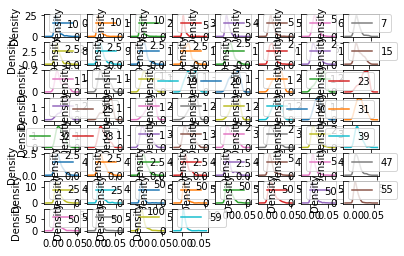

In [21]:
show_density_plots(df)

<p>This is useful to know. Many attributes have a <strong>skewed distribution.</strong> <strong>Box-Cox</strong> data transformation would benefit by correcting the skew which is usefuk.</p>
<strong>NOTE: Open the image name as <i>(univariate_plots_density)</i> to see in more detailed.</strong>

<h2>Multivariate Plots</h2>

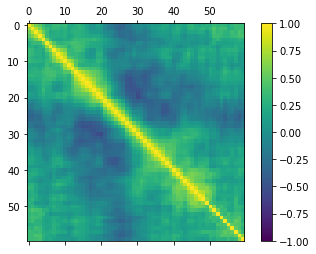

In [22]:
show_correlation_plot(df_correlation)

<p>The more <strong>yellowish</strong> means attributes are <strong>correlated.</strong> Then the more <strong>purple</strong> it is to be <strong>negative correlation.</strong></p>
<strong>NOTE: Open the image name as <i>(multivariate_plots_correlation)</i> to see in more detailed.</strong>

<h1>Target Variables</h1>
<h2>Class Distribution</h2>

<p>We need to determine what type of <strong>classification</strong> problem is this.</p>

In [23]:
df_class_distribution: DataFrame = get_class_distribution(df, 60)
df_class_distribution

60
M    111
R     97
dtype: int64

<p>This is a <strong>binary classification</strong> problem. Interesting because the classes are reasonably balanced between <strong>M (miner)</strong> and <strong>R (rocks).</strong></p>
<strong>NOTE: Open the image name as <i>(class_distribution)</i> to see in more detailed.</strong>

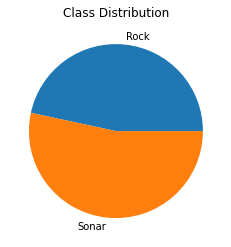

In [24]:
rocks: int = df_class_distribution.iloc[1]
sonar: int = df_class_distribution.iloc[0]
pyplot.title("Class Distribution")
pyplot.pie([rocks, sonar], labels=["Rock", "Sonar"])
show_plot()

<p>Confirmed, that class distribution is balanced.</p>

<h1>Prepare Data</h1>

<h2>Feature Selection</h2>

<p>Why do we need to use feature selection? </p>
<p>
 1.<strong>Reduces Overfitting:</strong> Less redundant data means less opportunity to make decisions on noise. <br>
  2. <strong>Improves Accuracy:</strong> Less misleading data means modeling accuracy improves.<br>
    3. <strong>Reduces Training Time:</strong> Less data means that algorithms train faster.<br>
<p>

In [25]:
X: DataFrame = df.iloc[:, 0 : 60].astype(float)
Y: DataFrame = df.iloc[:, 60]
X # Column 0 to 59

0       1       2       3       4       5       6       7       8   \
0    0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1    0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2    0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3    0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4    0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
203  0.0187  0.0346  0.0168  0.0177  0.0393  0.1630  0.2028  0.1694  0.2328   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
205  0.0522  0.0437  0.0180  0.0292  0.0351  0.1171  0.1257  0.1178  0.1258   
206  0.0303  0.0353  0.0490  0.0608  0.0167  0.1354  0.1465  0.1123  0.1945   
207  0.0260  0.0363  0.0136  0.0272  0.0214  0.0338  0.0655  0.1400  0.1843   

         9   ...      50      51      52      53      54      55      56  \
0    0.2111  ...  0.0232  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180   
1    0.2872  ...  0.0125  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140   
2    0.6194  ...  0.0033  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316   
3    0.1264  ...  0.0241  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050   
4    0.4459  ...  0.0156  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
203  0.2684  ...  0.0203  0.0116  0.0098  0.0199  0.0033  0.0101  0.0065   
204  0.2154  ...  0.0051  0.0061  0.0093  0.0135  0.0063  0.0063  0.0034   
205  0.2529  ...  0.0155  0.0160  0.0029  0.0051  0.0062  0.0089  0.0140   
206  0.2354  ...  0.0042  0.0086  0.0046  0.0126  0.0036  0.0035  0.0034   
207  0.2354  ...  0.0181  0.0146  0.0129  0.0047  0.0039  0.0061  0.0040   

         57      58      59  
0    0.0084  0.0090  0.0032  
1    0.0049  0.0052  0.0044  
2    0.0164  0.0095  0.0078  
3    0.0044  0.0040  0.0117  
4    0.0048  0.0107  0.0094  
..      ...     ...     ...  
203  0.0115  0.0193  0.0157  
204  0.0032  0.0062  0.0067  
205  0.0138  0.0077  0.0031  
206  0.0079  0.0036  0.0048  
207  0.0036  0.0061  0.0115  

[208 rows x 60 columns]

In [26]:
Y # Column 60

0      R
1      R
2      R
3      R
4      R
      ..
203    M
204    M
205    M
206    M
207    M
Name: 60, Length: 208, dtype: object

<h3>Univariate Selection</h3>

<p>This process is simply selecting the <strong>best features of one characteristic.</strong> Which is the strongest relationship with the <strong>output variable.</strong></p>

In [27]:
univariate_selection(X, Y)

[2.76947227e-01 3.12836172e-01 2.57607246e-01 5.22356600e-01
 4.19520499e-01 1.21090758e-01 8.54699230e-02 3.99063367e-01
 1.68412856e+00 2.08995257e+00 2.89395104e+00 2.49726600e+00
 1.47261917e+00 4.67062447e-01 8.96269601e-02 3.97006160e-03
 5.45014525e-04 6.68306726e-03 5.21296607e-01 1.27389237e+00
 1.33129635e+00 8.80297547e-01 3.25085150e-01 9.64595178e-02
 1.17733743e-02 1.31087975e-02 5.38109726e-02 1.14167780e-01
 2.49800624e-02 3.09060700e-04 2.30380212e-01 6.55002088e-02
 2.43087797e-01 8.12184574e-01 1.83529467e+00 2.71819152e+00
 1.43128115e+00 4.54013489e-02 8.15514258e-02 2.74056736e-02
 9.18949396e-03 4.40002996e-01 8.88761744e-01 1.28767382e+00
 2.77966705e+00 2.15914802e+00 1.16334560e+00 9.56715439e-01
 6.35977962e-01 6.14716388e-02 1.59700811e-01 1.19280229e-01
 1.93934453e-02 3.36571616e-02 1.02377508e-02 1.38585112e-02
 7.70968750e-07 3.69810915e-02 1.70464977e-02 6.52995936e-03]
         10      11      35      44
0    0.1609  0.1582  0.8507  0.2641
1    0.4918 

True

<p>In this case, 4 attributes that provides <strong>highest score (10, 11, 35, 44) using chi2</strong></p>

<h3>Recursive Feature Selection</h3>

<p>Let's see what attributes will be removed and remain among the features.</p>
<p>I will be using <strong>DecisionTreeClassier</strong> to model and extract relevant and not relevant features.</p>

In [28]:
recursive_feature_elmination(X, Y)

Column: 0, Selected=False, Rank: 10
Column: 1, Selected=False, Rank: 26
Column: 2, Selected=False, Rank: 9
Column: 3, Selected=False, Rank: 5
Column: 4, Selected=False, Rank: 24
Column: 5, Selected=False, Rank: 21
Column: 6, Selected=False, Rank: 22
Column: 7, Selected=False, Rank: 19
Column: 8, Selected=False, Rank: 6
Column: 9, Selected=False, Rank: 25
Column: 10, Selected=True, Rank: 1
Column: 11, Selected=False, Rank: 33
Column: 12, Selected=False, Rank: 36
Column: 13, Selected=False, Rank: 43
Column: 14, Selected=False, Rank: 34
Column: 15, Selected=True, Rank: 1
Column: 16, Selected=False, Rank: 41
Column: 17, Selected=False, Rank: 11
Column: 18, Selected=False, Rank: 32
Column: 19, Selected=False, Rank: 14
Column: 20, Selected=False, Rank: 28
Column: 21, Selected=False, Rank: 38
Column: 22, Selected=False, Rank: 44
Column: 23, Selected=False, Rank: 46
Column: 24, Selected=False, Rank: 48
Column: 25, Selected=False, Rank: 50
Column: 26, Selected=False, Rank: 52
Column: 27, Select

True

<p>Interesting column 10, 51, 15 ranked first as selected features.</p>

<h3>Feature Importance</h3>
<p>This is the process on finding the <strong>feature importance</strong> of the dataset.</p>
<p>I will be using <strong>ExtraTreesClassifier</strong> to search the most important features in the dataset.</p>

In [29]:
feature_importance(X, Y)

[0.014 0.014 0.011 0.015 0.011 0.012 0.008 0.013 0.027 0.028 0.046 0.041
 0.023 0.012 0.015 0.015 0.021 0.015 0.013 0.02  0.027 0.017 0.014 0.014
 0.011 0.012 0.016 0.02  0.013 0.012 0.015 0.014 0.01  0.012 0.016 0.032
 0.028 0.009 0.011 0.012 0.011 0.013 0.016 0.019 0.033 0.017 0.02  0.025
 0.032 0.008 0.018 0.012 0.01  0.017 0.013 0.009 0.009 0.009 0.012 0.01 ]


True

In [56]:
X_train, X_validation, Y_train, Y_validation = get_resampling_data(X, Y, 0.20, 7)

<p>The simplest way to evaluate the performance of a machine learning algorithm is the usage of different training and test dataset.</p>
<p>This is the process on splitting the dataset.</p>
<p>I will be using <strong>80/20 rule, 80% allocated for training and 20% for validation dataset</strong>.</p>

<h1>Evaluation Algorithm Baseline</h1>

<p>On <strong>machine learning problem,</strong> we do not know which <strong>algorithm</strong> will perform well in this dataset.</p>
<p>Perhaps the next step is find the algorithm for this dataset with following configurations</p>
1. Test harness: 10 cross fold validation <br>
2. Model Training <br>
3. Model Evaluation scoring is accuracy

In [74]:
baseline_models: List[set] = [
    ("LR", LogisticRegression()),
    ("LDA", LinearDiscriminantAnalysis()),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier()),
    ("NB", GaussianNB()),
    ("SVM", SVC())
]
baseline_results: List[set] = evaluate_algorithms_baseline(10, 7, "accuracy", X_train, Y_train, baseline_models)   

LR Mean estimated Accuracy: 77.757%
LR Estimated Standard Deviation: 8.842%
LDA Mean estimated Accuracy: 77.868%
LDA Estimated Standard Deviation: 9.357%
KNN Mean estimated Accuracy: 75.882%
KNN Estimated Standard Deviation: 10.642%
CART Mean estimated Accuracy: 72.721%
CART Estimated Standard Deviation: 11.038%
NB Mean estimated Accuracy: 68.272%
NB Estimated Standard Deviation: 13.604%
SVM Mean estimated Accuracy: 76.507%
SVM Estimated Standard Deviation: 8.752%


<p>Perhaps, <strong>K-Nearest Neighbor and Support Vector Machine</strong> are worth checking for this problem.</p>
<p>KNN accuracy is <strong>76%</strong> abd SVM is <strong>77%</strong></p>

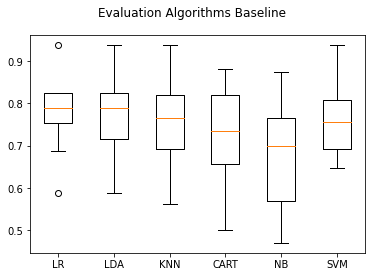

In [75]:
show_whisker_plots_for_evaluation(baseline_results[0], baseline_results[1], "Evaluation Algorithms Baseline")

<p><strong>KNN and SVM</strong> shows a promising results while <strong>NB</strong> shows poor performance.</p>
<p>Next section I will be repeating the same approach but this time let's transform and standardize the data.</p>

<h1>Evaluation Algorithm Standardize</h1>

<p>I will be evaluate the same algorithms with a standardize structure.</p>
<p>To avoid <strong>data leakage</strong> I will be using <strong>Pipelines</strong> on changing the structure and the process of building model with cross validation test harness.</p>
<p>Configurations would be</p>
1. Test harness: 10 cross fold validation <br>
2. Pipelines<br>
3. Standard Scaler<br>

In [76]:
pipelines: List[set]  = [
    ("ScaledLR", Pipeline([("Scaler", StandardScaler()),("LR", LogisticRegression())])),
    ("ScaledLDA", Pipeline([("Scaler", StandardScaler()),("LDA", LinearDiscriminantAnalysis())])),
    ("ScaledKNN", Pipeline([("Scaler", StandardScaler()),("KNN", KNeighborsClassifier())])),
    ("ScaledCART", Pipeline([("Scaler", StandardScaler()),("CART", LogisticRegression())])),
    ("ScaledNB", Pipeline([("Scaler", StandardScaler()),("NB", GaussianNB())])),
    ("ScaledSVM", Pipeline([("Scaler", StandardScaler()),("SVM", SVC())]))
]
scaled_results: list = evaluate_algorithms_standardize(10, 7, "accuracy", X_train, Y_train, pipelines)

Name:ScaledLR Mean:75.441% STD:6.793%
Name:ScaledLDA Mean:77.868% STD:9.357%
Name:ScaledKNN Mean:80.846% STD:10.800%
Name:ScaledCART Mean:75.441% STD:6.793%
Name:ScaledNB Mean:68.272% STD:13.604%
Name:ScaledSVM Mean:82.610% STD:8.181%


<p>Interesting results, there is a huge increase in SVM and KNN.</p>
<p>SVM just increased from <strong>77%</strong>to <strong>83% accuracy</strong>.</p>
<p>KNN just increased from <strong>76%</strong> to <strong>81%</strong>.</p>
<p>Let's plot the distribution.</p>

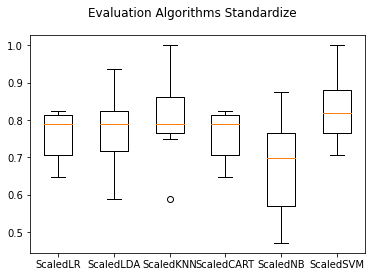

In [77]:
show_whisker_plots_for_evaluation(scaled_results[0], scaled_results[1], "Evaluation Algorithms Standardize")

<p>The distribution results strongly suggest to dig deeper into <strong>SVM and KNN</strong>.</p>
<p>It is very likely that the configuration beyond the deafult may yield even more accurate models.</p>

<h1>Improve Accuracy</h1>
<h2>Algorithm Tuning</h2>

<p>Machine learning algorithms have many <strong> parameters and each parameters </strong> can give an increase of the <strong>accuracy</strong>.</p>

<p>Take note that <strong>algorithm parameter tuning</strong> will improve the algorithm performance.</p>
<p>The following configurations for tuning are the ff.</p>
1. Test harness: 10 cross fold validation <br>
2. GridSearhCV <br>
3. Pipelines <br>
4. Standard Scaler

<h4>Tune Support Vector Machine</h4>


<p>Parameters to tune</p>
1. <strong>C</strong> int or float <br>
2. <strong>kernel</strong> ["rbf", "linear", "poly", "sigmoid"]

In [78]:
tune_svm(X_train, Y_train)

SVM Best score0.85 Params:{'SVC__C': 1.7, 'SVC__kernel': 'rbf'}
SVM mean=0.7426470588235293, std=0.07554230121830019, param={'SVC__C': 0.1, 'SVC__kernel': 'linear'}
SVM mean=0.5772058823529411, std=0.09029459666475738, param={'SVC__C': 0.1, 'SVC__kernel': 'poly'}
SVM mean=0.6011029411764707, std=0.18443464594421374, param={'SVC__C': 0.1, 'SVC__kernel': 'rbf'}
SVM mean=0.7128676470588236, std=0.11657890555209026, param={'SVC__C': 0.1, 'SVC__kernel': 'sigmoid'}
SVM mean=0.7544117647058824, std=0.08233652672549402, param={'SVC__C': 0.3, 'SVC__kernel': 'linear'}
SVM mean=0.6507352941176471, std=0.10963035564519863, param={'SVC__C': 0.3, 'SVC__kernel': 'poly'}
SVM mean=0.7363970588235295, std=0.08214341123091076, param={'SVC__C': 0.3, 'SVC__kernel': 'rbf'}
SVM mean=0.7426470588235293, std=0.07554230121830019, param={'SVC__C': 0.3, 'SVC__kernel': 'sigmoid'}
SVM mean=0.7661764705882353, std=0.06933242599330883, param={'SVC__C': 0.5, 'SVC__kernel': 'linear'}
SVM mean=0.7106617647058824, std=0.

<p>The optimize parameters are <strong>C=1.7 and kernel="rbf"</strong> giving <strong>85% accuracy</strong></p>

<h4>Tune K-Nearest Neighbor </h4>

<p>Parameters to tune</p>
1. <strong>n_neighbors</strong> int or float <br>
2. <strong>metric</strong> ["euclidean", "manhattan", "minkowski"] <br>
3. <strong>weights</strong> ["uniform", "distance"]

In [79]:
tune_knn(X_train, Y_train)

KNN Best score 0.8356617647058823 Params:{'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
KNN mean=0.8356617647058823, std=0.08984514864640224, param={'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
KNN mean=0.8356617647058823, std=0.08984514864640224, param={'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1, 'KNN__weights': 'distance'}
KNN mean=0.8014705882352942, std=0.09494979095694822, param={'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'uniform'}
KNN mean=0.8014705882352942, std=0.09494979095694822, param={'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}
KNN mean=0.8084558823529411, std=0.10799628441801545, param={'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
KNN mean=0.8084558823529411, std=0.10799628441801545, param={'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5, 'KNN__weights': 'distance'}
KNN mean=0.7716911764705883, std=0.12509133

<p>The optimize parameters are <strong>n_neighbors=1, metric="euclidean", and weights="uniform"</strong> gving <strong>84% accuracy</strong></p>

<h2>Ensemble</h2>

<p>Another way to improve accuracy and model performance is ensembles.</p>
<p>It can give a boost in the accuracy of the model for the dataset.</p>
<p>The most popular methods for combining different predictions and different models.</p>
1. Bagging Algorithms<strong>(RandomForest, ExtraTreeClassifier, BaggingClassifier)</strong> <br>
2. Boosting Algorithms <strong>(AdaBoostClassifier, GradientBoostingClassifier)</strong><br>
3. Majority Voting<strong>(VotingClassifier with KNN)</strong>

Ensemble configurations
1. Test harness: 10 cross fold validation
2. Metric is cross validation score

<h3>Bagging Algorithms</h3>
<p>Bagging means bootstrap aggregation which involves taking multiple samples from training dataset.</p>

In [80]:
bagging_ensembles: List[set] = [
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("BC", BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=7))
]
bagging_ensembles_results: list = make_ensemble_methods(bagging_ensembles, X_train, Y_train)

Ensemble method:RF mean:80.294% std:10.784%
Ensemble method:ET mean:85.662% std:8.143%
Ensemble method:BC mean:76.691% std:10.456%


<p>Interesting results, ExtraTressClassifier gives and <strong>86% accuracy</strong> while BaggingClassifier is the lowest.</p>
<p>Let's plot the distribution results.</p>

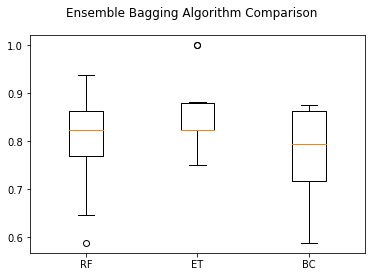

In [81]:
show_whisker_plots_for_evaluation(bagging_ensembles_results[0], bagging_ensembles_results[1], "Ensemble Bagging Algorithm Comparison")

<h3>Boosting Algorithm</h3>
<p>Boosting, simply creates a models that attempt to correcy the mistakes of the models.</p>

In [82]:
boosting_ensembles: List[set] = [
    ("AB", AdaBoostClassifier()),
    ("GBM", GradientBoostingClassifier())
]
boosting_ensembles_results: list = make_ensemble_methods(boosting_ensembles, X_train, Y_train)

Ensemble method:AB mean:78.272% std:7.245%
Ensemble method:GBM mean:80.184% std:13.191%


<p>Stochastic Gradient Boosting gives <strong>80% of accuracy</strong> and AdaBoost is only <strong>78% of accuracy</strong>.</p>

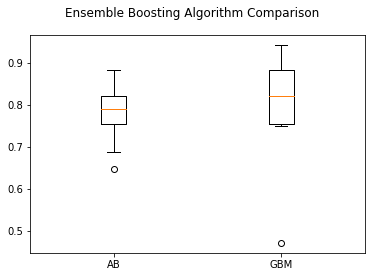

In [83]:
show_whisker_plots_for_evaluation(boosting_ensembles_results[0], boosting_ensembles_results[1], "Ensemble Boosting Algorithm Comparison")

<h3>Majority Voting</h3>
<p>This is method that <strong>combines predictions</strong> from multiple machine learning models.</p>
<p>This is similar to stacking algorithm.</p>

In [84]:
voting_ensembles: List[set] = [
    ("KNN2", KNeighborsClassifier(n_neighbors=2)),
    ("KNN4", KNeighborsClassifier(n_neighbors=4)),
    ("KNN6", KNeighborsClassifier(n_neighbors=6)),
    ("KNN8", KNeighborsClassifier(n_neighbors=8)),
    ("KNN10", KNeighborsClassifier(n_neighbors=10))
]

In [85]:
scores: float = majority_voting(voting_ensembles, X_train, Y_train)

In [86]:
scores

(71.65441176470588, 12.740389637455628)

<p>KNN10 gives <strong>72% accuracy after stacking each algorithms </strong></p>

<h1>Finalize Model</h1>

<p>I feel that <strong>Support Vector Machine</strong> is the most promising algorithm in this problem.</p>
<p>It provides low complexity and stable model for this dataset.</p>
<p>I will be finalizing the model by creating a file using <strong>pickle</strong> library and then load the modal for later usage.</p>
<p>Base in our findings SVM performs better when the structure of the dataset is standardize.</p>

In [70]:
svc_model: SVC = finalize_model(X_train, Y_train, X_validation, Y_validation)

Accuracy Score 90.476%
Confusion Matrix [[25  2]
 [ 2 13]]
Classification Report               precision    recall  f1-score   support

           M       0.93      0.93      0.93        27
           R       0.87      0.87      0.87        15

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42



<p>We can see that accuracy is incresed to <strong>90%</strong> on validation dataset.</p>

<h2>Save the model</h2>

In [71]:
filename: str = "svm_finalized_model.sav"
save_model(filename, svc_model)

<p>It will create a file under this folder.</p>

<h2>Load the model</h2>

In [73]:
load_model(filename, X_validation, Y_validation)

0.6428571428571429
